<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Practical 2b - Predicting House Prices</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [1]:
from tensorflow import keras
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print('keras: ', keras.__version__)

keras:  2.2.4-tf


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Objectives
After completing this practical exercise, students should be able to:
1. [Build a neural network model to predict house prices](#demo)
2. [Exercise- tuning several model parameters](#exc)

## 1. Predicting house prices (a regression example) <a id='demo' />

### 1.1 The Boston Housing Price dataset

We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the 
suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset has only 506 samples, split between 404 training samples and 102 test samples. Let's take a look at the data:

In [3]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [4]:
train_data.shape

(404, 13)

In [5]:
print(train_data[100])

[6.1290e-02 2.0000e+01 3.3300e+00 1.0000e+00 4.4290e-01 7.6450e+00
 4.9700e+01 5.2119e+00 5.0000e+00 2.1600e+02 1.4900e+01 3.7707e+02
 3.0100e+00]


In [6]:
test_data.shape

(102, 13)


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features (details are shown below) and each "feature" in the input data (e.g. the crime rate is a feature) has a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12, others between 0 and 100...

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [7]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

The prices are typically between $10,000  -  $50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not inflation-adjusted.

### 1.2 Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to 
automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:

In [8]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our workflow any quantity computed on the test data, even for something as simple as data normalization.

In [9]:
print(train_data[100])

[-0.39914449  0.35890566 -1.14281587  3.89358447 -0.97702129  1.9437178
 -0.69198737  0.72576261 -0.51114231 -1.1428069  -1.62718308  0.23710757
 -1.34300395]


### 1.3 Building our network


Because so few samples are available, we will be using a very small network with two 
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using 
a small network is one way to mitigate overfitting.

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                        input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


Our network ends with a single unit, and no activation (i.e. linear layer). This is a typical setup for scalar regression. Because the last layer is purely linear, the network is free to learn to predict values in any range.

Note that we are compiling the network with the `mse` loss function -- Mean Squared Error, the square of the difference between the predictions and the targets, a widely used loss function for regression problems.

We are also monitoring a new metric during training: `mae`. This stands for Mean Absolute Error. It is simply the absolute value of the difference between the predictions and the targets. For instance, a MAE of 0.5 on this problem would mean that our predictions are off by 
\$500 on average.

In [11]:
model.fit(train_data, train_targets, validation_split =0.2, epochs = 200, batch_size = 1)

Train on 323 samples, validate on 81 samples
Epoch 1/200
323/323 [==============================] - 2s 5ms/sample - loss: 178.4693 - mae: 10.2227 - val_loss: 44.1963 - val_mae: 4.4928
Epoch 2/200
323/323 [==============================] - 1s 3ms/sample - loss: 28.1654 - mae: 3.4941 - val_loss: 25.2607 - val_mae: 3.5833
Epoch 3/200
323/323 [==============================] - 1s 3ms/sample - loss: 19.5540 - mae: 2.8768 - val_loss: 14.9192 - val_mae: 2.7480
Epoch 4/200
323/323 [==============================] - 1s 3ms/sample - loss: 16.3263 - mae: 2.5914 - val_loss: 14.1526 - val_mae: 2.6899
Epoch 5/200
323/323 [==============================] - 1s 4ms/sample - loss: 13.8739 - mae: 2.4639 - val_loss: 15.7096 - val_mae: 2.7501
Epoch 6/200
323/323 [==============================] - 1s 5ms/sample - loss: 13.3816 - mae: 2.3355 - val_loss: 12.2108 - val_mae: 2.5636
Epoch 7/200
323/323 [==============================] - 1s 4ms/sample - loss: 12.3194 - mae: 2.3106 - val_loss: 13.0787 - val_mae: 2

323/323 [==============================] - 1s 2ms/sample - loss: 5.7532 - mae: 1.6216 - val_loss: 16.7205 - val_mae: 2.8176
Epoch 61/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.6324 - mae: 1.5319 - val_loss: 17.0604 - val_mae: 2.5344
Epoch 62/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.5976 - mae: 1.5175 - val_loss: 17.5482 - val_mae: 2.5354
Epoch 63/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.4466 - mae: 1.5939 - val_loss: 14.9496 - val_mae: 2.5240
Epoch 64/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.0951 - mae: 1.4920 - val_loss: 17.7106 - val_mae: 2.6445
Epoch 65/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.4897 - mae: 1.5584 - val_loss: 17.1355 - val_mae: 2.5429
Epoch 66/200
323/323 [==============================] - 1s 2ms/sample - loss: 5.1571 - mae: 1.5212 - val_loss: 14.9143 - val_mae: 2.4553
Epoch 67/200
323/323 [==============================] 

Epoch 120/200
323/323 [==============================] - 1s 3ms/sample - loss: 3.9189 - mae: 1.3009 - val_loss: 16.7056 - val_mae: 2.4401
Epoch 121/200
323/323 [==============================] - 1s 3ms/sample - loss: 3.6811 - mae: 1.2182 - val_loss: 13.9517 - val_mae: 2.3575
Epoch 122/200
323/323 [==============================] - 1s 3ms/sample - loss: 3.5568 - mae: 1.2280 - val_loss: 17.0128 - val_mae: 2.4896
Epoch 123/200
323/323 [==============================] - 1s 3ms/sample - loss: 3.7089 - mae: 1.2786 - val_loss: 15.4910 - val_mae: 2.4877
Epoch 124/200
323/323 [==============================] - 1s 2ms/sample - loss: 4.0739 - mae: 1.3318 - val_loss: 16.3631 - val_mae: 2.5450
Epoch 125/200
323/323 [==============================] - 1s 2ms/sample - loss: 3.5983 - mae: 1.2692 - val_loss: 17.5710 - val_mae: 2.4985
Epoch 126/200
323/323 [==============================] - 1s 3ms/sample - loss: 3.6232 - mae: 1.2541 - val_loss: 15.3243 - val_mae: 2.4040
Epoch 127/200
323/323 [===========

323/323 [==============================] - 1s 2ms/sample - loss: 2.6104 - mae: 1.1522 - val_loss: 14.6226 - val_mae: 2.5415
Epoch 180/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.4869 - mae: 1.1097 - val_loss: 14.9607 - val_mae: 2.4901
Epoch 181/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.8103 - mae: 1.1472 - val_loss: 15.2513 - val_mae: 2.5131
Epoch 182/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.5705 - mae: 1.0835 - val_loss: 17.7377 - val_mae: 2.6472
Epoch 183/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.6789 - mae: 1.1150 - val_loss: 16.3586 - val_mae: 2.5312
Epoch 184/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.8413 - mae: 1.0984 - val_loss: 14.0020 - val_mae: 2.5388
Epoch 185/200
323/323 [==============================] - 1s 2ms/sample - loss: 2.5991 - mae: 1.0938 - val_loss: 13.1820 - val_mae: 2.4985
Epoch 186/200
323/323 [=========================

As you can see, the model very quickly overfits to the training data, so we should stop it before it overfits. Now the question is when to stop? We will use K-fold validation to figure out in the next secsion.  

Because you'll need to instantiate the same model multiple times, you use a function to construct it.

In [12]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### 1.4 Validating our approach using K-fold validation

To evaluate our network while we keep adjusting its parameters (e.g. the number of epochs), we use K-fold cross-validation because we have so few data points. It splits the data into K partitions, then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

In [13]:
from tensorflow.keras import backend as K
# Some memory clean-up
K.clear_session()

In [14]:
import numpy as np

k = 5
num_val_samples = len(train_data) // k
num_epochs = 120
all_scores = []

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
Train on 324 samples, validate on 80 samples
Epoch 1/120
324/324 [==============================] - 1s 4ms/sample - loss: 191.5869 - mae: 10.1326 - val_loss: 30.8879 - val_mae: 3.4316
Epoch 2/120
324/324 [==============================] - 1s 2ms/sample - loss: 27.0201 - mae: 3.6457 - val_loss: 22.6356 - val_mae: 2.7547
Epoch 3/120
324/324 [==============================] - 1s 2ms/sample - loss: 22.2576 - mae: 3.1892 - val_loss: 17.7842 - val_mae: 2.6901
Epoch 4/120
324/324 [==============================] - 1s 2ms/sample - loss: 18.1370 - mae: 2.9263 - val_loss: 15.8488 - val_mae: 2.3756
Epoch 5/120
324/324 [==============================] - 1s 2ms/sample - loss: 16.2374 - mae: 2.6827 - val_loss: 12.6371 - val_mae: 2.1143
Epoch 6/120
324/324 [==============================] - 1s 2ms/sample - loss: 14.4570 - mae: 2.5962 - val_loss: 13.3222 - val_mae: 2.5104
Epoch 7/120
324/324 [==============================] - 1s 2ms/sample - loss: 14.0459 - mae: 2.5276 - val_loss: 

324/324 [==============================] - 1s 2ms/sample - loss: 6.1826 - mae: 1.6210 - val_loss: 9.0881 - val_mae: 2.2528
Epoch 61/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.3614 - mae: 1.5848 - val_loss: 10.1884 - val_mae: 2.1301
Epoch 62/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.9562 - mae: 1.6030 - val_loss: 8.9754 - val_mae: 1.8863
Epoch 63/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.9269 - mae: 1.5998 - val_loss: 8.4950 - val_mae: 1.8584
Epoch 64/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.0402 - mae: 1.5686 - val_loss: 8.2146 - val_mae: 1.8986
Epoch 65/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.7301 - mae: 1.5701 - val_loss: 9.2250 - val_mae: 2.1330
Epoch 66/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.8202 - mae: 1.6117 - val_loss: 9.4281 - val_mae: 1.8807
Epoch 67/120
324/324 [==============================] - 1s 2

324/324 [==============================] - 1s 2ms/sample - loss: 3.9472 - mae: 1.3284 - val_loss: 8.5385 - val_mae: 1.9138
processing fold # 1
Train on 324 samples, validate on 80 samples
Epoch 1/120
324/324 [==============================] - 1s 4ms/sample - loss: 200.2631 - mae: 10.6419 - val_loss: 43.4214 - val_mae: 5.0336
Epoch 2/120
324/324 [==============================] - 1s 2ms/sample - loss: 29.5270 - mae: 3.5602 - val_loss: 20.0620 - val_mae: 3.4214
Epoch 3/120
324/324 [==============================] - 1s 2ms/sample - loss: 21.1604 - mae: 3.0177 - val_loss: 17.8533 - val_mae: 3.1456
Epoch 4/120
324/324 [==============================] - 1s 2ms/sample - loss: 17.6528 - mae: 2.7028 - val_loss: 15.0381 - val_mae: 3.0259
Epoch 5/120
324/324 [==============================] - 1s 2ms/sample - loss: 14.7928 - mae: 2.5703 - val_loss: 16.1892 - val_mae: 3.0351
Epoch 6/120
324/324 [==============================] - 1s 2ms/sample - loss: 13.6795 - mae: 2.3903 - val_loss: 14.0729 - val_

324/324 [==============================] - 1s 2ms/sample - loss: 5.1234 - mae: 1.5349 - val_loss: 12.2337 - val_mae: 2.6556
Epoch 60/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.8720 - mae: 1.5123 - val_loss: 11.9658 - val_mae: 2.5875
Epoch 61/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.8383 - mae: 1.5432 - val_loss: 13.3134 - val_mae: 2.8003
Epoch 62/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.6096 - mae: 1.4985 - val_loss: 15.6620 - val_mae: 2.7190
Epoch 63/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.7763 - mae: 1.4545 - val_loss: 9.9259 - val_mae: 2.3597
Epoch 64/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.6649 - mae: 1.4428 - val_loss: 17.7803 - val_mae: 2.9874
Epoch 65/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.5447 - mae: 1.4438 - val_loss: 12.5568 - val_mae: 2.6774
Epoch 66/120
324/324 [==============================] -

Epoch 119/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.8173 - mae: 1.1407 - val_loss: 21.9297 - val_mae: 2.8412
Epoch 120/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.8776 - mae: 1.2035 - val_loss: 14.4391 - val_mae: 2.5279
processing fold # 2
Train on 324 samples, validate on 80 samples
Epoch 1/120
324/324 [==============================] - 1s 4ms/sample - loss: 218.1128 - mae: 11.0426 - val_loss: 22.5374 - val_mae: 3.5735
Epoch 2/120
324/324 [==============================] - 1s 2ms/sample - loss: 31.6712 - mae: 3.8418 - val_loss: 15.9706 - val_mae: 3.0209
Epoch 3/120
324/324 [==============================] - 1s 2ms/sample - loss: 22.7739 - mae: 3.1863 - val_loss: 11.8251 - val_mae: 2.6756
Epoch 4/120
324/324 [==============================] - 1s 2ms/sample - loss: 17.8269 - mae: 2.7939 - val_loss: 11.6909 - val_mae: 2.6696
Epoch 5/120
324/324 [==============================] - 1s 2ms/sample - loss: 14.7806 - mae: 2.6555 - val_loss

324/324 [==============================] - 1s 2ms/sample - loss: 5.6796 - mae: 1.6009 - val_loss: 10.1907 - val_mae: 2.4150
Epoch 59/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.4486 - mae: 1.5367 - val_loss: 7.0041 - val_mae: 2.0137
Epoch 60/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.6566 - mae: 1.5391 - val_loss: 7.6085 - val_mae: 2.1402
Epoch 61/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.7992 - mae: 1.5294 - val_loss: 9.3565 - val_mae: 2.3544
Epoch 62/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.5544 - mae: 1.5069 - val_loss: 8.6923 - val_mae: 2.2726
Epoch 63/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.2540 - mae: 1.4796 - val_loss: 12.7693 - val_mae: 2.6298
Epoch 64/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.2223 - mae: 1.5150 - val_loss: 7.4636 - val_mae: 2.1565
Epoch 65/120
324/324 [==============================] - 1s 

324/324 [==============================] - 1s 2ms/sample - loss: 2.9076 - mae: 1.2057 - val_loss: 7.6273 - val_mae: 2.0737
Epoch 119/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.9970 - mae: 1.1150 - val_loss: 8.0070 - val_mae: 2.1958
Epoch 120/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.4303 - mae: 1.2319 - val_loss: 9.5216 - val_mae: 2.4327
processing fold # 3
Train on 324 samples, validate on 80 samples
Epoch 1/120
324/324 [==============================] - 1s 4ms/sample - loss: 197.2120 - mae: 10.1427 - val_loss: 36.9568 - val_mae: 4.2457
Epoch 2/120
324/324 [==============================] - 1s 2ms/sample - loss: 24.8924 - mae: 3.4030 - val_loss: 26.1399 - val_mae: 3.2422
Epoch 3/120
324/324 [==============================] - 1s 2ms/sample - loss: 18.6330 - mae: 2.9631 - val_loss: 23.2561 - val_mae: 3.0569
Epoch 4/120
324/324 [==============================] - 1s 2ms/sample - loss: 15.2794 - mae: 2.6865 - val_loss: 21.2531 - val_

324/324 [==============================] - 1s 2ms/sample - loss: 4.0471 - mae: 1.4545 - val_loss: 18.6431 - val_mae: 2.8500
Epoch 58/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.0507 - mae: 1.4566 - val_loss: 15.5809 - val_mae: 2.4004
Epoch 59/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.1828 - mae: 1.3870 - val_loss: 16.6029 - val_mae: 2.5189
Epoch 60/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.2025 - mae: 1.4493 - val_loss: 16.4619 - val_mae: 2.5567
Epoch 61/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.0895 - mae: 1.4166 - val_loss: 16.3900 - val_mae: 2.6764
Epoch 62/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.9342 - mae: 1.4294 - val_loss: 18.4723 - val_mae: 2.5888
Epoch 63/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.8215 - mae: 1.4023 - val_loss: 16.0803 - val_mae: 2.4735
Epoch 64/120
324/324 [==============================] 

Epoch 117/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.4195 - mae: 1.1211 - val_loss: 15.4110 - val_mae: 2.5838
Epoch 118/120
324/324 [==============================] - 1s 2ms/sample - loss: 1.9765 - mae: 0.9778 - val_loss: 19.6516 - val_mae: 3.1049
Epoch 119/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.0205 - mae: 1.0547 - val_loss: 17.2270 - val_mae: 2.6905
Epoch 120/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.3317 - mae: 1.0742 - val_loss: 15.4924 - val_mae: 2.7116
processing fold # 4
Train on 324 samples, validate on 80 samples
Epoch 1/120
324/324 [==============================] - 1s 4ms/sample - loss: 182.2348 - mae: 10.1056 - val_loss: 51.0856 - val_mae: 4.6270
Epoch 2/120
324/324 [==============================] - 1s 2ms/sample - loss: 29.0905 - mae: 3.6456 - val_loss: 44.7403 - val_mae: 4.0898
Epoch 3/120
324/324 [==============================] - 1s 3ms/sample - loss: 19.6147 - mae: 3.0475 - val_lo

324/324 [==============================] - 1s 2ms/sample - loss: 5.5815 - mae: 1.5652 - val_loss: 12.1428 - val_mae: 2.4199
Epoch 57/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.9126 - mae: 1.6309 - val_loss: 12.3171 - val_mae: 2.4557
Epoch 58/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.0380 - mae: 1.5607 - val_loss: 12.3705 - val_mae: 2.4918
Epoch 59/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.5549 - mae: 1.5828 - val_loss: 13.2298 - val_mae: 2.5574
Epoch 60/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.7753 - mae: 1.6068 - val_loss: 14.7033 - val_mae: 2.8129
Epoch 61/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.6810 - mae: 1.5425 - val_loss: 15.9862 - val_mae: 2.7940
Epoch 62/120
324/324 [==============================] - 1s 2ms/sample - loss: 5.4995 - mae: 1.5169 - val_loss: 11.8925 - val_mae: 2.3821
Epoch 63/120
324/324 [==============================] 

Epoch 116/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.3239 - mae: 1.2953 - val_loss: 13.4016 - val_mae: 2.7626
Epoch 117/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.7824 - mae: 1.2623 - val_loss: 14.5704 - val_mae: 2.8613
Epoch 118/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.8832 - mae: 1.3571 - val_loss: 10.7831 - val_mae: 2.3400
Epoch 119/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.9071 - mae: 1.3296 - val_loss: 10.8433 - val_mae: 2.3436
Epoch 120/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.8448 - mae: 1.3792 - val_loss: 11.3492 - val_mae: 2.4715


We can then compute the average of the per-epoch MAE scores for all folds:

In [15]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Let's plot this:

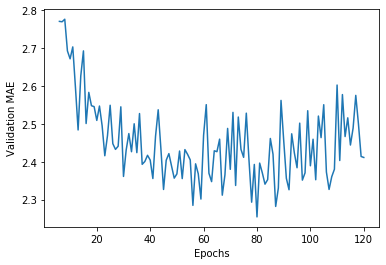

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1)[5:], average_mae_history[5:])
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It seems that validation MAE stops improving significantly after 50 epochs. We can now train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data:

In [17]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history = model.fit(train_data, train_targets, validation_split =0.2,
          epochs=50, batch_size=1, verbose=1)


Train on 323 samples, validate on 81 samples
Epoch 1/50
323/323 [==============================] - 1s 4ms/sample - loss: 212.7267 - mae: 10.9149 - val_loss: 46.8454 - val_mae: 4.7857
Epoch 2/50
323/323 [==============================] - 1s 3ms/sample - loss: 27.8497 - mae: 3.4460 - val_loss: 21.5750 - val_mae: 3.3239
Epoch 3/50
323/323 [==============================] - 1s 3ms/sample - loss: 19.6248 - mae: 2.9420 - val_loss: 15.2871 - val_mae: 2.9287
Epoch 4/50
323/323 [==============================] - 1s 3ms/sample - loss: 16.5835 - mae: 2.6455 - val_loss: 14.4579 - val_mae: 2.8861
Epoch 5/50
323/323 [==============================] - 1s 2ms/sample - loss: 14.5913 - mae: 2.4426 - val_loss: 13.0982 - val_mae: 2.8360
Epoch 6/50
323/323 [==============================] - 1s 2ms/sample - loss: 13.8170 - mae: 2.4475 - val_loss: 12.5205 - val_mae: 2.7959
Epoch 7/50
323/323 [==============================] - 1s 2ms/sample - loss: 12.6099 - mae: 2.3448 - val_loss: 11.6538 - val_mae: 2.6013
E

In [18]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


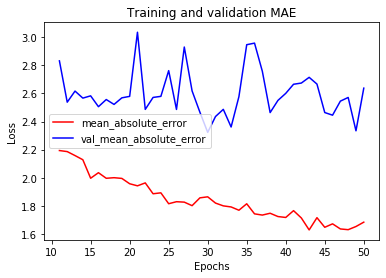

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

plt.plot(epochs[10:], mae[10:], 'r', label='mean_absolute_error')
plt.plot(epochs[10:], val_mae[10:], 'b', label='val_mean_absolute_error')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=2)
test_mae_score

102/102 - 0s - loss: 19.9372 - mae: 2.8951


2.895068

## 2. Exercise - tuning model parameters <a id='exc' />
Please train the above model in the below two scenerios: make the changes on the indicated training configurations (the rest no change). Train both models for 120 epochs. 

**Scenerio A**:
* change the batch size from 1 to 128

**Scenerio B**:
* change the learning rate (`optimizers.RMSprop(lr=0.001)`) from 0.001 to 0.0002

Observe the training and validation MAE curves for both scenerios.

Provide your codes & observations in the below boxes.

### 2.1 Scenerio A

In [21]:
# Task 1: Build the model and no changes
from tensorflow import keras
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [22]:
# Task 2: Compile and Train the model for 200 epochs. Change the batch size from 1 to 128
from tensorflow.keras import backend as K
import numpy as np

model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                        input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='mse', metrics=['mae'])
model.summary()

model.fit(train_data, train_targets, validation_split =0.2, epochs = 200, batch_size = 128)


K.clear_session()
k = 5
num_val_samples = len(train_data) // k
num_epochs = 120
all_scores = []

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=128, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history = model.fit(train_data, train_targets, validation_split =0.2, epochs=200, batch_size=128, verbose=1)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Train on 323 samples, validate on 81 samples
Epoch 1/200
323/323 [==============================] - 1s 2ms/sample - loss: 551.5434 - mae: 21.6466 - val_loss: 596.7510 - val_mae: 22.6800
Epoch 2/200
323/323 [==============================] - 0s 71us/sample - loss: 520.1315 - mae: 20.9450 - val_loss: 568.5994 - val_mae: 22.0923
Epoch 3/200
323/323 [==============================] -

Epoch 54/200
323/323 [==============================] - 0s 65us/sample - loss: 16.9752 - mae: 2.8827 - val_loss: 16.8391 - val_mae: 3.2185
Epoch 55/200
323/323 [==============================] - 0s 65us/sample - loss: 16.6078 - mae: 2.8598 - val_loss: 16.5219 - val_mae: 3.1685
Epoch 56/200
323/323 [==============================] - 0s 62us/sample - loss: 16.0265 - mae: 2.8060 - val_loss: 16.2516 - val_mae: 3.1469
Epoch 57/200
323/323 [==============================] - ETA: 0s - loss: 19.7839 - mae: 2.91 - 0s 56us/sample - loss: 15.7360 - mae: 2.7579 - val_loss: 16.1323 - val_mae: 3.1290
Epoch 58/200
323/323 [==============================] - 0s 68us/sample - loss: 15.4206 - mae: 2.7337 - val_loss: 16.2367 - val_mae: 3.1716
Epoch 59/200
323/323 [==============================] - 0s 62us/sample - loss: 15.3524 - mae: 2.7439 - val_loss: 15.9647 - val_mae: 3.1396
Epoch 60/200
323/323 [==============================] - 0s 56us/sample - loss: 14.8736 - mae: 2.6961 - val_loss: 15.1416 - val_m

323/323 [==============================] - 0s 62us/sample - loss: 8.1045 - mae: 2.0140 - val_loss: 13.3906 - val_mae: 2.4902
Epoch 113/200
323/323 [==============================] - 0s 62us/sample - loss: 8.1610 - mae: 2.0623 - val_loss: 12.4647 - val_mae: 2.5395
Epoch 114/200
323/323 [==============================] - 0s 59us/sample - loss: 8.3586 - mae: 2.0321 - val_loss: 13.2297 - val_mae: 2.5483
Epoch 115/200
323/323 [==============================] - 0s 65us/sample - loss: 8.0033 - mae: 2.0104 - val_loss: 12.6486 - val_mae: 2.4793
Epoch 116/200
323/323 [==============================] - 0s 65us/sample - loss: 8.0988 - mae: 2.0127 - val_loss: 13.0652 - val_mae: 2.5600
Epoch 117/200
323/323 [==============================] - 0s 59us/sample - loss: 7.9097 - mae: 1.9771 - val_loss: 12.6664 - val_mae: 2.4460
Epoch 118/200
323/323 [==============================] - 0s 59us/sample - loss: 7.9427 - mae: 2.0161 - val_loss: 12.5607 - val_mae: 2.4534
Epoch 119/200
323/323 [==================

323/323 [==============================] - 0s 65us/sample - loss: 6.7610 - mae: 1.8083 - val_loss: 12.8257 - val_mae: 2.4647
Epoch 172/200
323/323 [==============================] - 0s 65us/sample - loss: 6.5002 - mae: 1.7598 - val_loss: 13.1178 - val_mae: 2.4460
Epoch 173/200
323/323 [==============================] - 0s 62us/sample - loss: 6.3732 - mae: 1.7476 - val_loss: 13.4566 - val_mae: 2.4733
Epoch 174/200
323/323 [==============================] - 0s 63us/sample - loss: 6.3465 - mae: 1.7554 - val_loss: 13.4684 - val_mae: 2.5086
Epoch 175/200
323/323 [==============================] - 0s 62us/sample - loss: 6.5334 - mae: 1.7914 - val_loss: 13.8621 - val_mae: 2.4668
Epoch 176/200
323/323 [==============================] - 0s 62us/sample - loss: 6.3939 - mae: 1.7654 - val_loss: 13.5727 - val_mae: 2.4244
Epoch 177/200
323/323 [==============================] - 0s 68us/sample - loss: 6.4529 - mae: 1.7682 - val_loss: 13.4447 - val_mae: 2.5216
Epoch 178/200
323/323 [==================

324/324 [==============================] - 0s 68us/sample - loss: 40.8655 - mae: 4.9217 - val_loss: 35.8802 - val_mae: 4.0100
Epoch 30/120
324/324 [==============================] - 0s 62us/sample - loss: 37.8974 - mae: 4.7104 - val_loss: 33.8387 - val_mae: 3.8307
Epoch 31/120
324/324 [==============================] - 0s 58us/sample - loss: 35.1288 - mae: 4.4987 - val_loss: 31.9489 - val_mae: 3.6958
Epoch 32/120
324/324 [==============================] - 0s 68us/sample - loss: 32.8102 - mae: 4.3351 - val_loss: 30.1963 - val_mae: 3.6310
Epoch 33/120
324/324 [==============================] - 0s 58us/sample - loss: 30.3910 - mae: 4.1802 - val_loss: 28.6955 - val_mae: 3.5421
Epoch 34/120
324/324 [==============================] - 0s 62us/sample - loss: 28.4624 - mae: 4.0249 - val_loss: 27.3575 - val_mae: 3.4279
Epoch 35/120
324/324 [==============================] - 0s 62us/sample - loss: 26.8710 - mae: 3.8858 - val_loss: 26.2669 - val_mae: 3.3967
Epoch 36/120
324/324 [==================

Epoch 88/120
324/324 [==============================] - ETA: 0s - loss: 13.4909 - mae: 2.38 - 0s 62us/sample - loss: 10.3704 - mae: 2.2866 - val_loss: 9.4615 - val_mae: 2.1114
Epoch 89/120
324/324 [==============================] - 0s 65us/sample - loss: 10.2817 - mae: 2.2638 - val_loss: 9.3466 - val_mae: 2.1283
Epoch 90/120
324/324 [==============================] - 0s 68us/sample - loss: 10.2207 - mae: 2.2852 - val_loss: 9.1768 - val_mae: 2.1195
Epoch 91/120
324/324 [==============================] - 0s 58us/sample - loss: 10.1156 - mae: 2.2551 - val_loss: 9.2362 - val_mae: 2.0757
Epoch 92/120
324/324 [==============================] - 0s 58us/sample - loss: 10.2746 - mae: 2.2336 - val_loss: 9.2075 - val_mae: 2.1196
Epoch 93/120
324/324 [==============================] - 0s 68us/sample - loss: 10.0943 - mae: 2.2389 - val_loss: 9.0575 - val_mae: 2.1000
Epoch 94/120
324/324 [==============================] - 0s 58us/sample - loss: 10.0999 - mae: 2.2570 - val_loss: 9.2470 - val_mae: 2.1

Epoch 26/120
324/324 [==============================] - 0s 62us/sample - loss: 74.4489 - mae: 6.5592 - val_loss: 62.7624 - val_mae: 6.4254
Epoch 27/120
324/324 [==============================] - 0s 65us/sample - loss: 67.1674 - mae: 6.1771 - val_loss: 54.5033 - val_mae: 5.9543
Epoch 28/120
324/324 [==============================] - 0s 58us/sample - loss: 60.4228 - mae: 5.8032 - val_loss: 48.2254 - val_mae: 5.5907
Epoch 29/120
324/324 [==============================] - 0s 55us/sample - loss: 54.8766 - mae: 5.4855 - val_loss: 42.7459 - val_mae: 5.2428
Epoch 30/120
324/324 [==============================] - ETA: 0s - loss: 50.4910 - mae: 4.95 - 0s 58us/sample - loss: 50.0548 - mae: 5.1834 - val_loss: 38.7927 - val_mae: 4.9808
Epoch 31/120
324/324 [==============================] - 0s 62us/sample - loss: 46.3875 - mae: 4.9496 - val_loss: 35.2819 - val_mae: 4.7284
Epoch 32/120
324/324 [==============================] - 0s 58us/sample - loss: 42.6415 - mae: 4.7394 - val_loss: 32.5736 - val_m

Epoch 84/120
324/324 [==============================] - 0s 55us/sample - loss: 10.9143 - mae: 2.2855 - val_loss: 14.5655 - val_mae: 2.9880
Epoch 85/120
324/324 [==============================] - 0s 58us/sample - loss: 10.8708 - mae: 2.2833 - val_loss: 14.6995 - val_mae: 2.9848
Epoch 86/120
324/324 [==============================] - 0s 62us/sample - loss: 10.6839 - mae: 2.2667 - val_loss: 14.7811 - val_mae: 2.9912
Epoch 87/120
324/324 [==============================] - 0s 68us/sample - loss: 10.5590 - mae: 2.2630 - val_loss: 15.5708 - val_mae: 3.0542
Epoch 88/120
324/324 [==============================] - 0s 58us/sample - loss: 10.6133 - mae: 2.2610 - val_loss: 15.5044 - val_mae: 3.0429
Epoch 89/120
324/324 [==============================] - 0s 65us/sample - loss: 10.4286 - mae: 2.2474 - val_loss: 15.2888 - val_mae: 3.0346
Epoch 90/120
324/324 [==============================] - 0s 68us/sample - loss: 10.3807 - mae: 2.2779 - val_loss: 14.4259 - val_mae: 2.9797
Epoch 91/120
324/324 [=====

324/324 [==============================] - 0s 62us/sample - loss: 89.0799 - mae: 7.1685 - val_loss: 69.8938 - val_mae: 6.7740
Epoch 23/120
324/324 [==============================] - 0s 65us/sample - loss: 81.0416 - mae: 6.7989 - val_loss: 62.9887 - val_mae: 6.4294
Epoch 24/120
324/324 [==============================] - 0s 71us/sample - loss: 73.7206 - mae: 6.4772 - val_loss: 56.2687 - val_mae: 6.0803
Epoch 25/120
324/324 [==============================] - 0s 59us/sample - loss: 66.9346 - mae: 6.1472 - val_loss: 50.8900 - val_mae: 5.7688
Epoch 26/120
324/324 [==============================] - 0s 58us/sample - loss: 61.2960 - mae: 5.8887 - val_loss: 46.1890 - val_mae: 5.4865
Epoch 27/120
324/324 [==============================] - 0s 62us/sample - loss: 56.5501 - mae: 5.6238 - val_loss: 41.8391 - val_mae: 5.2506
Epoch 28/120
324/324 [==============================] - 0s 65us/sample - loss: 52.0818 - mae: 5.4065 - val_loss: 37.9763 - val_mae: 5.0236
Epoch 29/120
324/324 [==================

324/324 [==============================] - 0s 62us/sample - loss: 11.0757 - mae: 2.3378 - val_loss: 8.7885 - val_mae: 2.3753
Epoch 82/120
324/324 [==============================] - ETA: 0s - loss: 13.3741 - mae: 2.36 - 0s 61us/sample - loss: 10.8743 - mae: 2.3054 - val_loss: 8.4099 - val_mae: 2.3100
Epoch 83/120
324/324 [==============================] - 0s 65us/sample - loss: 10.9562 - mae: 2.3047 - val_loss: 8.5183 - val_mae: 2.3283
Epoch 84/120
324/324 [==============================] - 0s 62us/sample - loss: 10.6378 - mae: 2.2802 - val_loss: 8.5989 - val_mae: 2.3297
Epoch 85/120
324/324 [==============================] - 0s 58us/sample - loss: 11.0896 - mae: 2.3364 - val_loss: 10.0205 - val_mae: 2.5148
Epoch 86/120
324/324 [==============================] - 0s 65us/sample - loss: 10.6193 - mae: 2.2958 - val_loss: 9.0646 - val_mae: 2.4014
Epoch 87/120
324/324 [==============================] - 0s 65us/sample - loss: 10.3607 - mae: 2.2476 - val_loss: 8.7040 - val_mae: 2.3515
Epoch 88

324/324 [==============================] - 0s 61us/sample - loss: 206.9588 - mae: 11.9889 - val_loss: 195.3022 - val_mae: 11.3670
Epoch 19/120
324/324 [==============================] - 0s 65us/sample - loss: 187.9227 - mae: 11.2899 - val_loss: 178.2485 - val_mae: 10.7339
Epoch 20/120
324/324 [==============================] - 0s 62us/sample - loss: 169.6410 - mae: 10.6249 - val_loss: 161.9722 - val_mae: 10.1291
Epoch 21/120
324/324 [==============================] - 0s 58us/sample - loss: 152.5499 - mae: 9.9555 - val_loss: 148.0432 - val_mae: 9.5951
Epoch 22/120
324/324 [==============================] - 0s 62us/sample - loss: 137.3005 - mae: 9.3780 - val_loss: 134.8849 - val_mae: 9.1048
Epoch 23/120
324/324 [==============================] - 0s 62us/sample - loss: 123.3163 - mae: 8.7883 - val_loss: 123.5403 - val_mae: 8.7181
Epoch 24/120
324/324 [==============================] - 0s 62us/sample - loss: 110.9054 - mae: 8.2888 - val_loss: 113.2139 - val_mae: 8.3648
Epoch 25/120
324/324

Epoch 77/120
324/324 [==============================] - 0s 65us/sample - loss: 9.6101 - mae: 2.2746 - val_loss: 18.8435 - val_mae: 2.7723
Epoch 78/120
324/324 [==============================] - 0s 62us/sample - loss: 9.4848 - mae: 2.2621 - val_loss: 18.8529 - val_mae: 2.7663
Epoch 79/120
324/324 [==============================] - 0s 65us/sample - loss: 9.4158 - mae: 2.2389 - val_loss: 18.6266 - val_mae: 2.7615
Epoch 80/120
324/324 [==============================] - ETA: 0s - loss: 12.2205 - mae: 2.37 - 0s 65us/sample - loss: 9.3660 - mae: 2.2465 - val_loss: 18.6327 - val_mae: 2.7584
Epoch 81/120
324/324 [==============================] - 0s 65us/sample - loss: 9.1137 - mae: 2.2089 - val_loss: 18.1934 - val_mae: 2.7625
Epoch 82/120
324/324 [==============================] - 0s 68us/sample - loss: 9.1501 - mae: 2.2432 - val_loss: 18.6523 - val_mae: 2.7338
Epoch 83/120
324/324 [==============================] - 0s 65us/sample - loss: 8.8809 - mae: 2.1899 - val_loss: 18.0729 - val_mae: 2.7

Epoch 15/120
324/324 [==============================] - 0s 71us/sample - loss: 228.1371 - mae: 12.7441 - val_loss: 289.6640 - val_mae: 14.3873
Epoch 16/120
324/324 [==============================] - 0s 74us/sample - loss: 207.0766 - mae: 12.0435 - val_loss: 265.8384 - val_mae: 13.6380
Epoch 17/120
324/324 [==============================] - 0s 65us/sample - loss: 186.5993 - mae: 11.3061 - val_loss: 243.2082 - val_mae: 12.8959
Epoch 18/120
324/324 [==============================] - 0s 68us/sample - loss: 167.6477 - mae: 10.5973 - val_loss: 221.4406 - val_mae: 12.1314
Epoch 19/120
324/324 [==============================] - 0s 62us/sample - loss: 150.1849 - mae: 9.8922 - val_loss: 201.3971 - val_mae: 11.4132
Epoch 20/120
324/324 [==============================] - 0s 65us/sample - loss: 134.1599 - mae: 9.2860 - val_loss: 182.2540 - val_mae: 10.7063
Epoch 21/120
324/324 [==============================] - ETA: 0s - loss: 141.5847 - mae: 9.388 - 0s 74us/sample - loss: 119.5844 - mae: 8.6894 - 

324/324 [==============================] - 0s 62us/sample - loss: 11.0997 - mae: 2.3159 - val_loss: 16.4132 - val_mae: 2.9008
Epoch 74/120
324/324 [==============================] - 0s 65us/sample - loss: 11.0375 - mae: 2.3846 - val_loss: 16.4482 - val_mae: 2.9574
Epoch 75/120
324/324 [==============================] - 0s 62us/sample - loss: 10.9109 - mae: 2.3428 - val_loss: 16.3552 - val_mae: 2.8925
Epoch 76/120
324/324 [==============================] - 0s 62us/sample - loss: 10.8127 - mae: 2.3097 - val_loss: 16.1536 - val_mae: 2.9139
Epoch 77/120
324/324 [==============================] - 0s 62us/sample - loss: 10.7444 - mae: 2.3082 - val_loss: 16.0840 - val_mae: 2.8760
Epoch 78/120
324/324 [==============================] - 0s 62us/sample - loss: 10.6633 - mae: 2.2922 - val_loss: 15.7625 - val_mae: 2.8889
Epoch 79/120
324/324 [==============================] - 0s 61us/sample - loss: 10.3493 - mae: 2.2677 - val_loss: 15.7622 - val_mae: 2.8690
Epoch 80/120
324/324 [==================

323/323 [==============================] - 0s 59us/sample - loss: 366.0495 - mae: 16.8849 - val_loss: 410.7727 - val_mae: 18.1299
Epoch 12/200
323/323 [==============================] - 0s 62us/sample - loss: 344.0229 - mae: 16.2666 - val_loss: 386.6731 - val_mae: 17.4900
Epoch 13/200
323/323 [==============================] - 0s 62us/sample - loss: 321.4125 - mae: 15.6155 - val_loss: 363.6079 - val_mae: 16.8477
Epoch 14/200
323/323 [==============================] - 0s 59us/sample - loss: 299.6203 - mae: 14.9774 - val_loss: 340.3428 - val_mae: 16.1754
Epoch 15/200
323/323 [==============================] - 0s 59us/sample - loss: 277.7450 - mae: 14.3187 - val_loss: 316.5882 - val_mae: 15.4565
Epoch 16/200
323/323 [==============================] - 0s 65us/sample - loss: 255.7825 - mae: 13.6199 - val_loss: 293.3517 - val_mae: 14.7193
Epoch 17/200
323/323 [==============================] - 0s 59us/sample - loss: 234.4133 - mae: 12.9130 - val_loss: 270.7436 - val_mae: 13.9712
Epoch 18/200

323/323 [==============================] - 0s 65us/sample - loss: 13.0459 - mae: 2.4749 - val_loss: 15.4240 - val_mae: 2.9434
Epoch 70/200
323/323 [==============================] - 0s 65us/sample - loss: 12.7815 - mae: 2.4611 - val_loss: 15.4898 - val_mae: 2.9838
Epoch 71/200
323/323 [==============================] - 0s 62us/sample - loss: 12.7249 - mae: 2.4321 - val_loss: 15.2114 - val_mae: 2.9384
Epoch 72/200
323/323 [==============================] - 0s 55us/sample - loss: 12.3237 - mae: 2.4207 - val_loss: 15.2857 - val_mae: 2.9425
Epoch 73/200
323/323 [==============================] - 0s 65us/sample - loss: 12.3114 - mae: 2.4322 - val_loss: 14.8223 - val_mae: 2.8936
Epoch 74/200
323/323 [==============================] - 0s 68us/sample - loss: 11.9305 - mae: 2.3584 - val_loss: 14.7421 - val_mae: 2.8531
Epoch 75/200
323/323 [==============================] - 0s 62us/sample - loss: 11.9591 - mae: 2.3805 - val_loss: 14.5929 - val_mae: 2.8508
Epoch 76/200
323/323 [==================

323/323 [==============================] - 0s 65us/sample - loss: 7.7619 - mae: 1.9072 - val_loss: 14.7671 - val_mae: 2.6150
Epoch 129/200
323/323 [==============================] - 0s 65us/sample - loss: 7.6756 - mae: 1.9159 - val_loss: 14.9229 - val_mae: 2.6210
Epoch 130/200
323/323 [==============================] - 0s 65us/sample - loss: 7.6975 - mae: 1.9310 - val_loss: 15.7853 - val_mae: 2.6227
Epoch 131/200
323/323 [==============================] - 0s 65us/sample - loss: 7.8032 - mae: 1.9938 - val_loss: 14.6977 - val_mae: 2.5827
Epoch 132/200
323/323 [==============================] - 0s 68us/sample - loss: 7.6023 - mae: 1.9217 - val_loss: 14.9820 - val_mae: 2.6038
Epoch 133/200
323/323 [==============================] - ETA: 0s - loss: 5.3613 - mae: 1.784 - 0s 59us/sample - loss: 7.6256 - mae: 1.9200 - val_loss: 15.9097 - val_mae: 2.7222
Epoch 134/200
323/323 [==============================] - 0s 62us/sample - loss: 7.7702 - mae: 1.9372 - val_loss: 15.8394 - val_mae: 2.6688
Epo

323/323 [==============================] - 0s 62us/sample - loss: 6.2512 - mae: 1.7189 - val_loss: 15.5982 - val_mae: 2.5611
Epoch 187/200
323/323 [==============================] - 0s 62us/sample - loss: 6.1588 - mae: 1.7164 - val_loss: 15.8354 - val_mae: 2.5951
Epoch 188/200
323/323 [==============================] - 0s 55us/sample - loss: 6.2542 - mae: 1.7063 - val_loss: 18.0795 - val_mae: 2.8024
Epoch 189/200
323/323 [==============================] - 0s 55us/sample - loss: 6.5244 - mae: 1.8168 - val_loss: 15.5715 - val_mae: 2.6130
Epoch 190/200
323/323 [==============================] - 0s 65us/sample - loss: 6.3961 - mae: 1.7501 - val_loss: 16.3615 - val_mae: 2.5721
Epoch 191/200
323/323 [==============================] - 0s 65us/sample - loss: 6.2530 - mae: 1.7345 - val_loss: 15.3339 - val_mae: 2.5509
Epoch 192/200
323/323 [==============================] - 0s 56us/sample - loss: 6.2050 - mae: 1.7078 - val_loss: 15.3542 - val_mae: 2.5657
Epoch 193/200
323/323 [==================

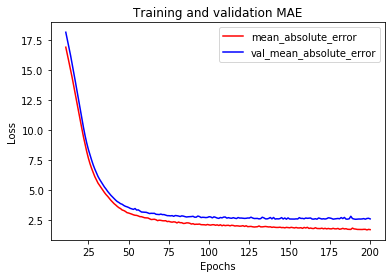

In [23]:
#Task 3: Plot the MAE (train & test) curves
import matplotlib.pyplot as plt
%matplotlib inline
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

plt.plot(epochs[10:], mae[10:], 'r', label='mean_absolute_error')
plt.plot(epochs[10:], val_mae[10:], 'b', label='val_mean_absolute_error')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=2)
test_mae_score

#Task 4: Comment on your model
With higher batch size, the model is 'smoother' but there is a drop of quality. Compare to the model on top, this model have a higher max and min loss rate.

### 2.2 Scenerio B

In [24]:
#Task 1: Build the model
from tensorflow import keras
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std
    


def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [25]:
#Task 2: Compile and Fit the model. Change the learning rate from 0.001 to 0.0002
model = models.Sequential()
model.add(layers.Dense(64, activation='relu',
                        input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(lr=0.0002), loss='mse', metrics=['mae'])
model.summary()

from tensorflow.keras import backend as K
import numpy as np
model.fit(train_data, train_targets, validation_split =0.2, epochs = 200, batch_size = 1)


K.clear_session()
k = 5
num_val_samples = len(train_data) // k
num_epochs = 120
all_scores = []

all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
history = model.fit(train_data, train_targets, validation_split =0.2, epochs=50, batch_size=1, verbose=1)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Train on 323 samples, validate on 81 samples
Epoch 1/200
323/323 [==============================] - 1s 4ms/sample - loss: 508.1220 - mae: 20.5266 - val_loss: 496.8917 - val_mae: 20.2473
Epoch 2/200
323/323 [==============================] - 1s 3ms/sample - loss: 323.7639 - mae: 15.4232 - val_loss: 253.9840 - val_mae: 13.1565
Epoch 3/200
323/323 [==============================] - 

323/323 [==============================] - 1s 3ms/sample - loss: 9.6353 - mae: 1.9173 - val_loss: 11.8070 - val_mae: 2.6465
Epoch 55/200
323/323 [==============================] - 1s 3ms/sample - loss: 9.4734 - mae: 1.9138 - val_loss: 11.4773 - val_mae: 2.6145
Epoch 56/200
323/323 [==============================] - 1s 3ms/sample - loss: 9.4709 - mae: 1.9102 - val_loss: 11.3010 - val_mae: 2.5550
Epoch 57/200
323/323 [==============================] - 1s 3ms/sample - loss: 9.3335 - mae: 1.9016 - val_loss: 11.3100 - val_mae: 2.5481
Epoch 58/200
323/323 [==============================] - 1s 3ms/sample - loss: 9.2085 - mae: 1.9083 - val_loss: 11.3315 - val_mae: 2.5232
Epoch 59/200
323/323 [==============================] - 1s 3ms/sample - loss: 8.6997 - mae: 1.9417 - val_loss: 11.5152 - val_mae: 2.6006
Epoch 60/200
323/323 [==============================] - 1s 3ms/sample - loss: 9.0990 - mae: 1.8729 - val_loss: 11.3613 - val_mae: 2.5555
Epoch 61/200
323/323 [==============================] 

Epoch 114/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.6726 - mae: 1.5696 - val_loss: 12.3737 - val_mae: 2.5267
Epoch 115/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.5289 - mae: 1.5758 - val_loss: 12.1917 - val_mae: 2.5106
Epoch 116/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.6114 - mae: 1.5728 - val_loss: 12.3885 - val_mae: 2.4995
Epoch 117/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.5807 - mae: 1.5571 - val_loss: 12.1428 - val_mae: 2.4921
Epoch 118/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.6470 - mae: 1.5513 - val_loss: 12.4164 - val_mae: 2.5197
Epoch 119/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.3104 - mae: 1.5643 - val_loss: 12.2523 - val_mae: 2.4958
Epoch 120/200
323/323 [==============================] - 1s 3ms/sample - loss: 6.3506 - mae: 1.5649 - val_loss: 12.2969 - val_mae: 2.5272
Epoch 121/200
323/323 [===========

323/323 [==============================] - 1s 3ms/sample - loss: 5.4255 - mae: 1.4185 - val_loss: 12.9723 - val_mae: 2.5445
Epoch 174/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.2939 - mae: 1.3923 - val_loss: 12.9460 - val_mae: 2.5640
Epoch 175/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.1099 - mae: 1.4018 - val_loss: 12.9256 - val_mae: 2.5925
Epoch 176/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.1111 - mae: 1.4105 - val_loss: 13.4171 - val_mae: 2.5720
Epoch 177/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.1097 - mae: 1.4021 - val_loss: 12.8851 - val_mae: 2.5188
Epoch 178/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.1533 - mae: 1.3911 - val_loss: 12.9842 - val_mae: 2.5570
Epoch 179/200
323/323 [==============================] - 1s 3ms/sample - loss: 5.2353 - mae: 1.3746 - val_loss: 13.0525 - val_mae: 2.5347
Epoch 180/200
323/323 [=========================

324/324 [==============================] - 1s 3ms/sample - loss: 8.4634 - mae: 1.9682 - val_loss: 10.5373 - val_mae: 2.0187
Epoch 33/120
324/324 [==============================] - 1s 3ms/sample - loss: 8.6126 - mae: 1.8916 - val_loss: 8.0468 - val_mae: 1.7800
Epoch 34/120
324/324 [==============================] - 1s 3ms/sample - loss: 8.1171 - mae: 1.8687 - val_loss: 7.8544 - val_mae: 1.9845
Epoch 35/120
324/324 [==============================] - 1s 3ms/sample - loss: 8.3142 - mae: 1.9245 - val_loss: 7.1185 - val_mae: 1.6664
Epoch 36/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.9374 - mae: 1.9360 - val_loss: 7.2268 - val_mae: 1.8009
Epoch 37/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.6880 - mae: 1.8273 - val_loss: 6.9912 - val_mae: 1.7076
Epoch 38/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.5457 - mae: 1.8324 - val_loss: 6.6912 - val_mae: 1.6816
Epoch 39/120
324/324 [==============================] - 1s 3

324/324 [==============================] - 1s 2ms/sample - loss: 5.2133 - mae: 1.4361 - val_loss: 6.8287 - val_mae: 1.8220
Epoch 93/120
324/324 [==============================] - 1s 3ms/sample - loss: 5.2298 - mae: 1.4236 - val_loss: 6.5076 - val_mae: 1.9228
Epoch 94/120
324/324 [==============================] - 1s 3ms/sample - loss: 5.3417 - mae: 1.4026 - val_loss: 8.3687 - val_mae: 2.2563
Epoch 95/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.8052 - mae: 1.4408 - val_loss: 10.8870 - val_mae: 2.2581
Epoch 96/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.5862 - mae: 1.3713 - val_loss: 8.0455 - val_mae: 2.1258
Epoch 97/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.8927 - mae: 1.4384 - val_loss: 6.6805 - val_mae: 1.9146
Epoch 98/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.8851 - mae: 1.4600 - val_loss: 6.3717 - val_mae: 1.7806
Epoch 99/120
324/324 [==============================] - 1s 3

324/324 [==============================] - 1s 2ms/sample - loss: 7.0371 - mae: 1.7518 - val_loss: 11.0586 - val_mae: 2.5463
Epoch 32/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.4317 - mae: 1.7310 - val_loss: 11.6445 - val_mae: 2.5668
Epoch 33/120
324/324 [==============================] - 1s 2ms/sample - loss: 7.0681 - mae: 1.7736 - val_loss: 9.9470 - val_mae: 2.4424
Epoch 34/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.8134 - mae: 1.7361 - val_loss: 13.1076 - val_mae: 2.7089
Epoch 35/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.6835 - mae: 1.7705 - val_loss: 9.9182 - val_mae: 2.4174
Epoch 36/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.8444 - mae: 1.7798 - val_loss: 12.5089 - val_mae: 2.6654
Epoch 37/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.6494 - mae: 1.7641 - val_loss: 9.0669 - val_mae: 2.3253
Epoch 38/120
324/324 [==============================] - 1

Epoch 91/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.3734 - mae: 1.2640 - val_loss: 18.8866 - val_mae: 2.9837
Epoch 92/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.7187 - mae: 1.2871 - val_loss: 15.0482 - val_mae: 2.7118
Epoch 93/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.5810 - mae: 1.2457 - val_loss: 20.0674 - val_mae: 3.0567
Epoch 94/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.4331 - mae: 1.2875 - val_loss: 20.8286 - val_mae: 3.0394
Epoch 95/120
324/324 [==============================] - 1s 3ms/sample - loss: 3.3475 - mae: 1.2858 - val_loss: 15.8266 - val_mae: 2.7416
Epoch 96/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.1364 - mae: 1.2112 - val_loss: 17.8013 - val_mae: 2.8725
Epoch 97/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.2208 - mae: 1.2389 - val_loss: 19.1842 - val_mae: 3.0260
Epoch 98/120
324/324 [===================

324/324 [==============================] - 1s 2ms/sample - loss: 8.1963 - mae: 1.8390 - val_loss: 7.8236 - val_mae: 2.2071
Epoch 31/120
324/324 [==============================] - 1s 2ms/sample - loss: 8.0261 - mae: 1.8820 - val_loss: 8.0062 - val_mae: 2.3085
Epoch 32/120
324/324 [==============================] - 1s 2ms/sample - loss: 7.8373 - mae: 1.8492 - val_loss: 7.7575 - val_mae: 2.2399
Epoch 33/120
324/324 [==============================] - 1s 2ms/sample - loss: 7.8721 - mae: 1.7533 - val_loss: 10.8560 - val_mae: 2.6511
Epoch 34/120
324/324 [==============================] - 1s 2ms/sample - loss: 7.6381 - mae: 1.7723 - val_loss: 8.6836 - val_mae: 2.3755
Epoch 35/120
324/324 [==============================] - 1s 2ms/sample - loss: 7.2635 - mae: 1.7605 - val_loss: 8.2010 - val_mae: 2.2532
Epoch 36/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.4714 - mae: 1.7428 - val_loss: 8.5366 - val_mae: 2.3144
Epoch 37/120
324/324 [==============================] - 1s 3

324/324 [==============================] - 1s 2ms/sample - loss: 4.2811 - mae: 1.3705 - val_loss: 10.0328 - val_mae: 2.2837
Epoch 91/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.0084 - mae: 1.3201 - val_loss: 8.5707 - val_mae: 2.2592
Epoch 92/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.0843 - mae: 1.3669 - val_loss: 8.4955 - val_mae: 2.2075
Epoch 93/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.0425 - mae: 1.2869 - val_loss: 12.2159 - val_mae: 2.4444
Epoch 94/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.2025 - mae: 1.3643 - val_loss: 8.8951 - val_mae: 2.2098
Epoch 95/120
324/324 [==============================] - 1s 2ms/sample - loss: 4.0801 - mae: 1.3840 - val_loss: 9.2584 - val_mae: 2.1760
Epoch 96/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.8502 - mae: 1.3582 - val_loss: 8.9106 - val_mae: 2.2215
Epoch 97/120
324/324 [==============================] - 1s 

324/324 [==============================] - 1s 2ms/sample - loss: 6.4336 - mae: 1.7495 - val_loss: 19.8889 - val_mae: 2.7779
Epoch 30/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.2547 - mae: 1.6868 - val_loss: 18.5789 - val_mae: 2.4790
Epoch 31/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.1026 - mae: 1.7342 - val_loss: 18.2556 - val_mae: 2.5704
Epoch 32/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.1299 - mae: 1.6858 - val_loss: 17.4635 - val_mae: 2.6101
Epoch 33/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.4014 - mae: 1.7342 - val_loss: 17.4262 - val_mae: 2.5519
Epoch 34/120
324/324 [==============================] - 1s 2ms/sample - loss: 6.0728 - mae: 1.7034 - val_loss: 16.6865 - val_mae: 2.5135
Epoch 35/120
324/324 [==============================] - 1s 3ms/sample - loss: 6.2533 - mae: 1.6791 - val_loss: 16.9197 - val_mae: 2.4296
Epoch 36/120
324/324 [==============================] 

Epoch 89/120
324/324 [==============================] - 1s 3ms/sample - loss: 3.1267 - mae: 1.2569 - val_loss: 17.8487 - val_mae: 2.8282
Epoch 90/120
324/324 [==============================] - 1s 3ms/sample - loss: 3.0263 - mae: 1.2617 - val_loss: 18.3555 - val_mae: 2.8526
Epoch 91/120
324/324 [==============================] - 1s 2ms/sample - loss: 3.0549 - mae: 1.2297 - val_loss: 18.8652 - val_mae: 2.7050
Epoch 92/120
324/324 [==============================] - 1s 3ms/sample - loss: 2.9226 - mae: 1.2611 - val_loss: 21.2711 - val_mae: 2.8850
Epoch 93/120
324/324 [==============================] - 1s 3ms/sample - loss: 3.0098 - mae: 1.2137 - val_loss: 18.6517 - val_mae: 2.8166
Epoch 94/120
324/324 [==============================] - 1s 2ms/sample - loss: 2.8819 - mae: 1.2363 - val_loss: 16.7742 - val_mae: 2.7155
Epoch 95/120
324/324 [==============================] - 1s 3ms/sample - loss: 2.9274 - mae: 1.1889 - val_loss: 17.8341 - val_mae: 2.6743
Epoch 96/120
324/324 [===================

324/324 [==============================] - 1s 3ms/sample - loss: 7.6073 - mae: 1.7968 - val_loss: 13.1163 - val_mae: 2.6350
Epoch 29/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.9134 - mae: 1.8048 - val_loss: 11.7795 - val_mae: 2.3450
Epoch 30/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.5884 - mae: 1.7560 - val_loss: 13.1020 - val_mae: 2.6556
Epoch 31/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.6450 - mae: 1.7307 - val_loss: 12.5238 - val_mae: 2.4506
Epoch 32/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.4821 - mae: 1.7939 - val_loss: 11.9092 - val_mae: 2.3875
Epoch 33/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.6100 - mae: 1.7509 - val_loss: 12.0654 - val_mae: 2.4885
Epoch 34/120
324/324 [==============================] - 1s 3ms/sample - loss: 7.3036 - mae: 1.7396 - val_loss: 11.7786 - val_mae: 2.3994
Epoch 35/120
324/324 [==============================] 

Epoch 88/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.1595 - mae: 1.3218 - val_loss: 12.8670 - val_mae: 2.5493
Epoch 89/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.4667 - mae: 1.3726 - val_loss: 14.1321 - val_mae: 2.6852
Epoch 90/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.2115 - mae: 1.3234 - val_loss: 13.5953 - val_mae: 2.5070
Epoch 91/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.2382 - mae: 1.3719 - val_loss: 14.0638 - val_mae: 2.6373
Epoch 92/120
324/324 [==============================] - 1s 3ms/sample - loss: 3.9681 - mae: 1.3350 - val_loss: 13.7864 - val_mae: 2.6443
Epoch 93/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.3051 - mae: 1.3493 - val_loss: 14.3288 - val_mae: 2.5777
Epoch 94/120
324/324 [==============================] - 1s 3ms/sample - loss: 4.1817 - mae: 1.3278 - val_loss: 13.7509 - val_mae: 2.5916
Epoch 95/120
324/324 [===================

323/323 [==============================] - 1s 3ms/sample - loss: 7.5861 - mae: 1.8732 - val_loss: 12.6963 - val_mae: 2.6717
Epoch 28/50
323/323 [==============================] - 1s 2ms/sample - loss: 7.8427 - mae: 1.8200 - val_loss: 14.5478 - val_mae: 2.6817
Epoch 29/50
323/323 [==============================] - 1s 3ms/sample - loss: 7.4997 - mae: 1.8615 - val_loss: 14.6323 - val_mae: 2.7369
Epoch 30/50
323/323 [==============================] - 1s 3ms/sample - loss: 7.2762 - mae: 1.8071 - val_loss: 14.0780 - val_mae: 2.6415
Epoch 31/50
323/323 [==============================] - 1s 3ms/sample - loss: 7.5330 - mae: 1.7945 - val_loss: 13.5363 - val_mae: 2.4864
Epoch 32/50
323/323 [==============================] - 1s 3ms/sample - loss: 7.4724 - mae: 1.7784 - val_loss: 13.0817 - val_mae: 2.6475
Epoch 33/50
323/323 [==============================] - 1s 2ms/sample - loss: 7.3972 - mae: 1.7635 - val_loss: 13.6379 - val_mae: 2.5577
Epoch 34/50
323/323 [==============================] - 1s 3m

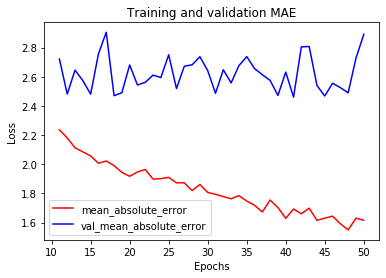

In [26]:
#Task 3: Plot the MAE (train & test) curves
import matplotlib.pyplot as plt
%matplotlib inline
mae = history.history['mae']
val_mae = history.history['val_mae']

epochs = range(1, len(mae) + 1)

plt.plot(epochs[10:], mae[10:], 'r', label='mean_absolute_error')
plt.plot(epochs[10:], val_mae[10:], 'b', label='val_mean_absolute_error')
plt.title('Training and validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=2)
test_mae_score

#Task 4: Comment on your model
After reducing the learn rate, the network is slower in training and validation but the model look almost the same. We can see this from epochs 40 of the current model and epichs 43 of the model on top.